# Python Computation Stress

In [1]:
# Import modules
import decimal
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression

In [2]:
print(f"Tensorflow version: {tf.__version__}")
print(f"Tensorflow Datasets version: {tfds.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Numpy version: {np.__version__}")

Tensorflow version: 2.1.0
Tensorflow Datasets version: 3.1.0
Matplotlib version: 3.3.4
Numpy version: 1.18.1


In [3]:
print(f"C3 Server version: {c3.Cluster.hosts()[0].serverInfo['buildCITag']}")

C3 Server version: 7.19.1.10-1


# Plain Python Computation

In [ ]:
# Python Computation Stress Cell

def compute_pi(n):
    decimal.getcontext().prec = n + 1
    C = 426880 * decimal.Decimal(10005).sqrt()
    K = 6.
    M = 1.
    X = 1
    L = 13591409
    S = L

    for i in range(1, n):
        M = M * (K ** 3 - 16 * K) / ((i + 1) ** 3)
        L += 545140134
        X *= -262537412640768000
        S += decimal.Decimal(M * L) / X

        pi = C / S
    return pi

compute_pi(4000)

# Data Preparation

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /home/c3/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


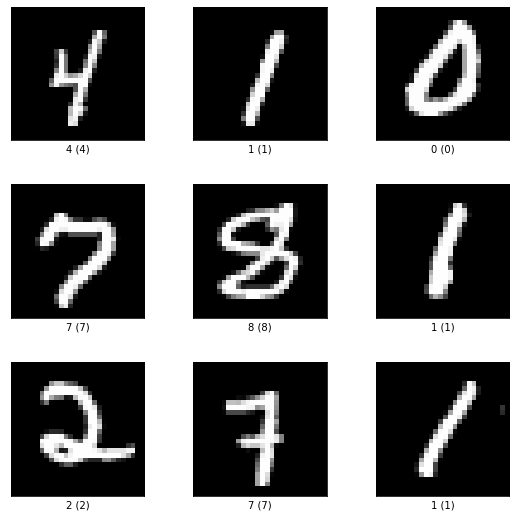

In [4]:
# Plain Tensorflow training cell
ds, info = tfds.load('mnist', split='train', with_info=True)

# Make C3 logging quiet
import logging
logging.getLogger('c3.Client').propagate = False

fig = tfds.show_examples(ds, info)

In [26]:
# From MNIST tensorflow tutorial
# Load dataset
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_img)
ds_test = ds_test.map(normalize_img)

# collect all examples and stack'em up for numpy arrays
X_train = []
Y_train = []
for x, y in ds_train:
    X_train.append(x.numpy())
    Y_train.append(y.numpy())

X_train = np.stack(X_train, axis=0)
Y_train = np.stack(Y_train, axis=0)

Y_train = Y_train.reshape(-1,1)

X_train = X_train.reshape((X_train.shape[0], -1))

X_test = []
Y_test = []
for x, y in ds_test:
    X_test.append(x.numpy())
    Y_test.append(y.numpy())

X_test = np.stack(X_test, axis=0)
Y_test = np.stack(Y_test, axis=0)

Y_test = Y_test.reshape(-1,1)

X_test = X_test.reshape((X_test.shape[0], -1))

DS_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
DS_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

# Plain Tensorflow

In [6]:
# model evaluation function

def keras_model(model, X):
    return model(X)

def sklearn_model(model, X):
    return model.predict(X)

In [7]:
batch_size = 128

In [8]:
# Dict 
model_dict = {}

In [38]:
# Logistic Regression

model = Pipeline([('logreg', LogisticRegression(max_iter=1000))])

model.fit(X_train[:500], Y_train[:500])

model_dict['Logistic Regression'] = (model, sklearn_model)

/home/c3/.conda/envs/py-dataanalysis/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [33]:
# Simple sequential model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)),
  tf.keras.layers.Dense(10)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    DS_train.batch(batch_size),
    epochs=6,
    validation_data=DS_test.batch(batch_size),
)

model_dict['Dense'] = (model, keras_model)

Train for 469 steps, validate for 79 steps
Epoch 1/6
469/469 [==============================] - 18s 39ms/step - loss: 0.4182 - sparse_categorical_accuracy: 0.8858 - val_loss: 0.2220 - val_sparse_categorical_accuracy: 0.9378
Epoch 2/6
469/469 [==============================] - 16s 34ms/step - loss: 0.1991 - sparse_categorical_accuracy: 0.9428 - val_loss: 0.1701 - val_sparse_categorical_accuracy: 0.9497
Epoch 3/6
469/469 [==============================] - 16s 33ms/step - loss: 0.1538 - sparse_categorical_accuracy: 0.9562 - val_loss: 0.1430 - val_sparse_categorical_accuracy: 0.9581
Epoch 4/6
469/469 [==============================] - 16s 34ms/step - loss: 0.1256 - sparse_categorical_accuracy: 0.9643 - val_loss: 0.1263 - val_sparse_categorical_accuracy: 0.9613
Epoch 5/6
469/469 [==============================] - 16s 34ms/step - loss: 0.1064 - sparse_categorical_accuracy: 0.9698 - val_loss: 0.1152 - val_sparse_categorical_accuracy: 0.9655
Epoch 6/6
469/469 [==============================] -

In [46]:
# Support Vector Classifier

model = Pipeline([('svc', SVC(kernel='poly'))])

# We train on fewer examples for SVC because of large memory requirements of SVC
model.fit(X_train[:4000], Y_train[:4000])
#
model_dict['SVC'] = (model, sklearn_model)

/home/c3/.conda/envs/py-dataanalysis/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [41]:
## Simple CNN (Currently CNN model crashes the python kernel when evaluating on Cluster 2)
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=(784,)),
    tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

model.fit(
    DS_train.batch(batch_size),
    #epochs=6,
    #epochs=3,
    epochs=1,
    validation_data=DS_test.batch(batch_size),
)

model_dict['CNN'] = (model, keras_model)

Train for 469 steps, validate for 79 steps
469/469 [==============================] - 118s 251ms/step - loss: 0.2335 - sparse_categorical_accuracy: 0.9324 - val_loss: 0.0950 - val_sparse_categorical_accuracy: 0.9721


In [47]:
for model_key in model_dict:
    #metric = tf.keras.metrics.SparseCategoricalAccuracy()
    metric = tf.keras.metrics.Accuracy()
    model = model_dict[model_key][0]
    eval_function = model_dict[model_key][1]
    Y = eval_function(model, X_test)
    try:
        Y = Y.numpy()
    except:
        pass
    if len(Y.shape) > 1:
        # Flatten result
        Y = np.argmax(Y, axis=1)
    metric.update_state(Y_test, Y)
    print(f"Model {model_key} achieves {metric.result().numpy()*100:.2f}% Accuracy")

Model Dense achieves 96.76% Accuracy
Model Logistic Regression achieves 85.58% Accuracy
Model CNN achieves 97.21% Accuracy
Model SVC achieves 93.16% Accuracy


# Tensorflow with C3

In [28]:
# C3 Tensorflow training cell

# Put data onto the C3 platform
X_train_spec = c3.FileSourceCreateSpec(
    locationPrefix="StressTest"
)
X_train_source_spec = c3.FileSourceSpec.createFromNumpy(X_train, X_train_spec)
Y_train_spec = c3.FileSourceCreateSpec(
    locationPrefix="StressTest"
)
Y_train_source_spec = c3.FileSourceSpec.createFromNumpy(Y_train, Y_train_spec)
X_test_spec = c3.FileSourceCreateSpec(
    locationPrefix="StressTest"
)
X_test_source_spec = c3.FileSourceSpec.createFromNumpy(X_test, X_test_spec)
Y_test_spec = c3.FileSourceCreateSpec(
    locationPrefix="StressTest"
)
Y_test_source_spec = c3.FileSourceSpec.createFromNumpy(Y_test, Y_test_spec)

In [21]:
pipeline_dict = {}

In [22]:
# Logistic Regression Pipeline

lrPipe = c3.SklearnPipe(
    name = "logisticRegression",
    technique=c3.SklearnTechnique(
        name = "linear_model.LogisticRegression",
        # calls predict function
        processingFunctionName="predict",
        hyperParameters={"random_state": 42}
    )
)

logisticRegression = c3.MLSerialPipeline(
    name = "lrPipeline",
    steps = [
        c3.MLStep(
            name="lrStep",
            pipe=lrPipe
        )
    ],
    scoringMetrics=c3.MLScoringMetric.toScoringMetricMap(scoringMetricList=[c3.MLAccuracyMetric()])
)
pipeline_dict['Logistic Regression'] = logisticRegression

In [29]:
# Train pipeline
trained_logisticRegression = logisticRegression.train(
    input=c3.Dataset.fromNdArrayStreamable(X_train_source_spec),
    targetOutput=c3.Dataset.fromNdArrayStreamable(Y_train_source_spec))

In [30]:
trained_logisticRegression

c3.MLSerialPipeline(
 name='lrPipeline',
 noTrainScore=False,
 scoringMetrics=c3.Mapp<string, anyof(MLScoringMetric<any,any>)>({'MLAccuracyMetric': c3.MLAccuracyMetric()}),
 trainingScores=c3.Mapp<string, double>({'MLAccuracyMetric': 0.9346166666666667}),
 untrainableOverride=False,
 trainedDate=datetime.datetime(2021, 7, 27, 16, 38, tzinfo=datetime.timezone.utc),
 trainingStatus='TRAINED',
 steps=c3.Arry<MLStep>([c3.MLStep(
          name='lrStep',
          pipe=c3.SklearnPipe(
                 name='logisticRegression',
                 implType='SklearnPipeV7d13',
                 noTrainScore=False,
                 typeVersion='7.19.1',
                 untrainableOverride=False,
                 technique=c3.SklearnTechnique(
                             name='linear_model.LogisticRegression',
                             hyperParameters=c3.Mapp<string, any>({'random_state': 42.0}),
                             processingFunctionName='predict',
                             keepI

In [48]:
pipeline_dict['Logistic Regression'] = trained_logisticRegression

In [66]:
# Dense sequential model pipeline
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)),
  tf.keras.layers.Dense(10)
])

class seq_model(tf.keras.Model):
    def __init__(self, **kwargs):
        inp = tf.keras.layers.Input(shape=(784,))
        dense = tf.keras.layers.Dense(64, activation='relu')(inp)
        cats = tf.keras.layers.Dense(10, activation='linear')(dense)
        out = tf.keras.layers.Reshape((-1,1))(tf.cast(tf.math.argmax(cats, axis=1), tf.float32))
        super().__init__(**kwargs)
        self.train_model = tf.keras.Model(inputs=inp, outputs=cats)
        self.eval_model = tf.keras.Model(inputs=inp, outputs=out)

    def call(self, X, training=False, **kwargs):
        if training:
            return self.train_model(X, training=training, **kwargs)
        else:
            return self.eval_model(X, training=training, **kwargs)

model = seq_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# Build keras pipeline
technique = c3.KerasTechnique(numEpochs=6, batchSize=batch_size)
dense_keras_pipe = c3.KerasPipe(name='denseClassifier',
                          technique=technique).upsertNativeModel(model, upsertModelDefOnly=False)

# Build final pipeline
dense_keras_pipeline = c3.MLSerialPipeline(
    name = "kerasPipeline",
    steps=[
        c3.MLStep(name="classifier",
                  pipe=dense_keras_pipe)],
    scoringMetrics=c3.MLScoringMetric.toScoringMetricMap(scoringMetricList=[c3.MLAccuracyMetric()])
)

NotImplementedError: 

The traceback for the inline method is:
  File "Z66e905400b22b25861b4c6184de6e7d5M_.TypeSystemBase", line 1014, in inline_traceback_impl
  File "KerasPipe.py", line 455, in upsertNativeModel
    _update_technique(this, model)
  File "KerasPipe.py", line 412, in _update_technique
    this.technique.modelDef = model.to_json()
  File "/home/c3/.conda/envs/py-dataanalysis/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/network.py", line 1254, in to_json
    model_config = self._updated_config()
  File "/home/c3/.conda/envs/py-dataanalysis/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/network.py", line 1232, in _updated_config
    config = self.get_config()
  File "/home/c3/.conda/envs/py-dataanalysis/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/network.py", line 917, in get_config
    raise NotImplementedError


In [50]:
# Train dense pipeline
dense_keras_pipe_trained = dense_keras_pipeline.train(
    input=c3.Dataset.fromNdArrayStreamable(X_train_source_spec),
    targetOutput=c3.Dataset.fromNdArrayStreamable(Y_train_source_spec))

In [57]:
dense_keras_pipe_trained.score(
    input=c3.Dataset.fromNdArrayStreamable(X_test_source_spec),
    targetOutput=c3.Dataset.fromNdArrayStreamable(Y_test_source_spec))

c3.Mapp<string, double>({'MLAccuracyMetric': 0.0})

In [62]:
r = trained_logisticRegression.process(input=c3.Dataset.fromNdArrayStreamable(X_test_source_spec))

c3.Dataset(
 sourceSpec=c3.FileNdArraySourceSpec(
              storageFormat='NPY',
              optimalFileSize=64000000,
              id='3b70e0e3-9680-448d-b8c3-9c96fc5f9e0a',
              meta=c3.Meta(
                     tenantTagId=152,
                     tenant='dev',
                     tag='tc03d',
                     created=datetime.datetime(2021, 7, 27, 18, 14, 12, tzinfo=datetime.timezone.utc),
                     createdBy='mkrafcz2@illinois.edu',
                     updated=datetime.datetime(2021, 7, 27, 18, 14, 12, tzinfo=datetime.timezone.utc),
                     updatedBy='mkrafcz2@illinois.edu',
                     timestamp=datetime.datetime(2021, 7, 27, 18, 14, 12, tzinfo=datetime.timezone.utc),
                     fetchInclude='[]',
                     fetchType='FileNdArraySourceSpec'),
              version=2,
              typeIdent='FISS:FNDASS',
              location='FileSourceSpec/3b70e0e3-9680-448d-b8c3-9c96fc5f9e0a',
              uploadI

In [67]:
d = c3.Dataset.toNumpy(dataset=r)
d

array([[2.],
       [0.],
       [4.],
       ...,
       [8.],
       [0.],
       [5.]])

In [68]:
d.shape

(10000, 1)

In [59]:
res = dense_keras_pipe_trained.process(input=c3.Dataset.fromNdArrayStreamable(X_test_source_spec))
res

c3.Tensor(
 shape=c3.Arry<int>([10000, 10]),
 m_data=c3.Arry<double>([-2.101316213607788,
          -5.776638984680176,
          9.153287887573242,
          ...,
          -6.13359260559082,
          3.8262906074523926,
          -1.6244990825653076]))

In [ ]:
dense_keras_pipe_trained.process()

In [53]:
# Save pipeline
pipeline_dict['Dense'] = dense_keras_pipe_trained

In [ ]:
## SVC pipeline
#svcPipe = c3.SklearnPipe(
#    name = "svcPipe",
#    technique=c3.SklearnTechnique(
#        name = "svm.SVC",
#        # calls predict function
#        processingFunctionName="predict",
#        hyperParameters={"kernel": "poly"}
#    )
#)
#
#svcPipeline = c3.MLSerialPipeline(
#    name = "svcPipeline",
#    steps = [
#        c3.MLStep(
#            name="svcStep",
#            pipe=svcPipe
#        )
#    ],
##    scoringMetrics=c3.MLScoringMetric.toScoringMetricMap(scoringMetricList=[c3.MLAccuracyMetric()])
#)

In [ ]:
## Train pipeline
#trainedSVCPipe = svcPipe.train(
#    input=c3.Dataset.fromNdArrayStreamable(X_train_source_spec),
#    targetOutput=c3.Dataset.fromNdArrayStreamable(Y_train_source_spec))

In [ ]:
## Save pipeline
#pipeline_dict['SVC'] = trainedSVCPipe

In [ ]:
## Simple CNN 
#model = tf.keras.models.Sequential([
#    tf.keras.layers.Reshape((28, 28, 1), input_shape=(784,)),
#    tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(10)
#])
#
#model.compile(
#    optimizer=tf.keras.optimizers.Adam(0.001),
#    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
#)

In [ ]:
## Build keras pipeline
#technique = c3.KerasTechnique(numEpochs=6, batchSize=batch_size)
#cnn_keras_pipe = c3.KerasPipe(name='cnnClassifier',
#                          technique=technique).upsertNativeModel(model, upsertModelDefOnly=False)

In [ ]:
## Build final pipeline
#cnn_keras_pipeline = c3.MLSerialPipeline(
#    name = "cnnKerasPipeline",
#    steps=[
#        c3.MLStep(name="classifier",
#                  pipe=cnn_keras_pipe)],
##    scoringMetrics=c3.MLScoringMetric.toScoringMetricMap(scoringMetricList=[c3.MLBinaryAccuracyMetric(threshold=0.5)])
#)

In [ ]:
#cnn_keras_pipe_trained = cnn_keras_pipeline.train(
#    input=c3.Dataset.fromNdArrayStreamable(X_train_source_spec),
#    targetOutput=c3.Dataset.fromNdArrayStreamable(Y_train_source_spec))

In [ ]:
## Save pipeline
#pipeline_dict['CNN'] = cnn_keras_pipe_trained

In [54]:
# Summarize Trained pipelines

scores_dict = {}

for pipeline_name in pipeline_dict:
    pipeline = pipeline_dict[pipeline_name]
    Y_pred_res = pipeline.process(c3.Dataset.fromNdArrayStreamable(X_test_source_spec))
    Y_pred = c3.Dataset.toNumpy(dataset=Y_pred_res)
    if len(Y_pred.shape) == 2:
        if Y_pred.shape[1] == 10:
            Y_pred = np.argmax(Y_pred, axis=1)
        Y_pred = Y_pred.reshape(-1)
    num_count = sum(Y_pred == Y_test)
    scores_dict[pipeline_name] = num_count/Y_test.shape[0]

for pipeline_name in scores_dict:
    print(f"Pipeline {pipeline_name} achieves accuracy {scores_dict[pipeline_name]*100:.2f}%")

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [ ]:
#trainedLr.score(
#    input=c3.Dataset.fromNdArrayStreamable(X_test_source_spec),
#    targetOutput=c3.Dataset.fromNdArrayStreamable(Y_test_source_spec),
#    spec=c3.MLScoreSpec())

# Save models

In [ ]:
# Upsert models for 'later'
upserted_pipelines = {}

for pipeline_name in pipeline_dict:
    upserted_pipe = pipeline_dict[pipeline_name].upsert()
    upserted_pipelines[pipeline_name] = upserted_pipe

# Fetch trained model, and test

In [ ]:
# Load C3 model Tensorflow training cell
# Summarize Trained pipelines

scores_dict = {}

for pipeline_name in upserted_pipelines:
    try:
        pipeline = c3.MLSerialPipeline.get(upserted_pipelines[pipeline_name].id)
    except:
        pass
    if pipeline is None:
        continue
    
    #pipeline = upserted_pipelines[pipeline_name]
    Y_pred_res = pipeline.process(c3.Dataset.fromNdArrayStreamable(X_test_source_spec))
    Y_pred = c3.Dataset.toNumpy(dataset=Y_pred_res)
    if len(Y_pred.shape) == 2:
        if Y_pred.shape[1] == 10:
            Y_pred = np.argmax(Y_pred, axis=1)
        Y_pred = Y_pred.reshape(-1)
    num_count = sum(Y_pred == Y_test)
    scores_dict[pipeline_name] = num_count/Y_test.shape[0]

for pipeline_name in scores_dict:
    print(f"Pipeline {pipeline_name} achieves accuracy {scores_dict[pipeline_name]*100:.2f}%")